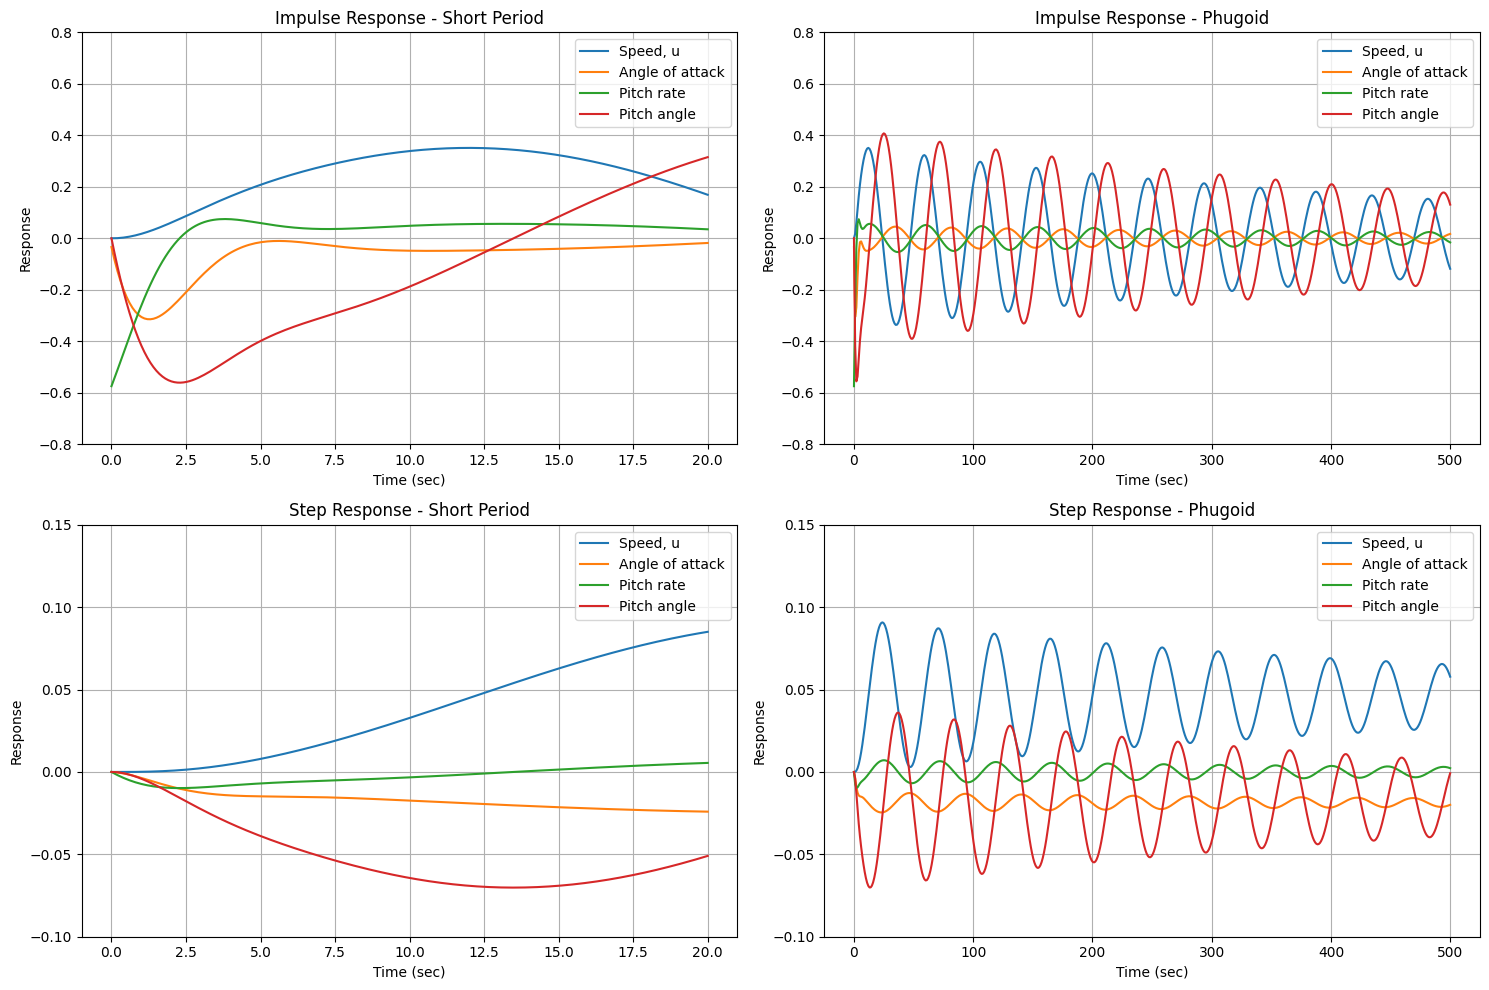

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv

A = np.array([
    [-0.0212, 0.0466, 0.0000, -0.1153],
    [-0.2229, -0.5839, 0.9404, 0.0000],
    [0.0150, -0.5031, -0.5015, 0.0000],
    [0.0000, 0.0000, 1.0000, 0.0000]
])

B = np.array([[0.0000], 
              [-0.0340], 
              [-0.5746], 
              [0.0000]])

# One degree input
eta0 = np.pi/180  # Convert 1 degree to radians

def impulse_response(t):
    return np.dot(expm(A * t), B).flatten()

def step_response(t):
    # Implementing equation 6.43:
    # x(t) = [e^(At) - I]A^(-1)Bη0
    A_inv = inv(A)
    exp_At = expm(A * t)
    return eta0 * np.dot(exp_At - np.eye(4), np.dot(A_inv, B)).flatten()

# Time vectors
t_short = np.linspace(0, 20, 200)
t_long = np.linspace(0, 500, 500)

impulse_short = np.array([impulse_response(t) for t in t_short])
impulse_long = np.array([impulse_response(t) for t in t_long])
step_short = np.array([step_response(t) for t in t_short])
step_long = np.array([step_response(t) for t in t_long])

plt.figure(figsize=(15, 10))

# Short period impulse response
plt.subplot(2, 2, 1)
plt.plot(t_short, impulse_short[:, 0], label='Speed, u')
plt.plot(t_short, impulse_short[:, 1], label='Angle of attack')
plt.plot(t_short, impulse_short[:, 2], label='Pitch rate')
plt.plot(t_short, impulse_short[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Impulse Response - Short Period')
plt.legend()
plt.ylim(-0.8, 0.8)

# Long period (phugoid) impulse response
plt.subplot(2, 2, 2)
plt.plot(t_long, impulse_long[:, 0], label='Speed, u')
plt.plot(t_long, impulse_long[:, 1], label='Angle of attack')
plt.plot(t_long, impulse_long[:, 2], label='Pitch rate')
plt.plot(t_long, impulse_long[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Impulse Response - Phugoid')
plt.legend()
plt.ylim(-0.8, 0.8)

# Short period step response
plt.subplot(2, 2, 3)
plt.plot(t_short, step_short[:, 0], label='Speed, u')
plt.plot(t_short, step_short[:, 1], label='Angle of attack')
plt.plot(t_short, step_short[:, 2], label='Pitch rate')
plt.plot(t_short, step_short[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Step Response - Short Period')
plt.legend()
plt.ylim(-0.1, 0.15)

# Long period (phugoid) step response
plt.subplot(2, 2, 4)
plt.plot(t_long, step_long[:, 0], label='Speed, u')
plt.plot(t_long, step_long[:, 1], label='Angle of attack')
plt.plot(t_long, step_long[:, 2], label='Pitch rate')
plt.plot(t_long, step_long[:, 3], label='Pitch angle')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Step Response - Phugoid')
plt.legend()
plt.ylim(-0.1, 0.15)

plt.tight_layout()
plt.show()

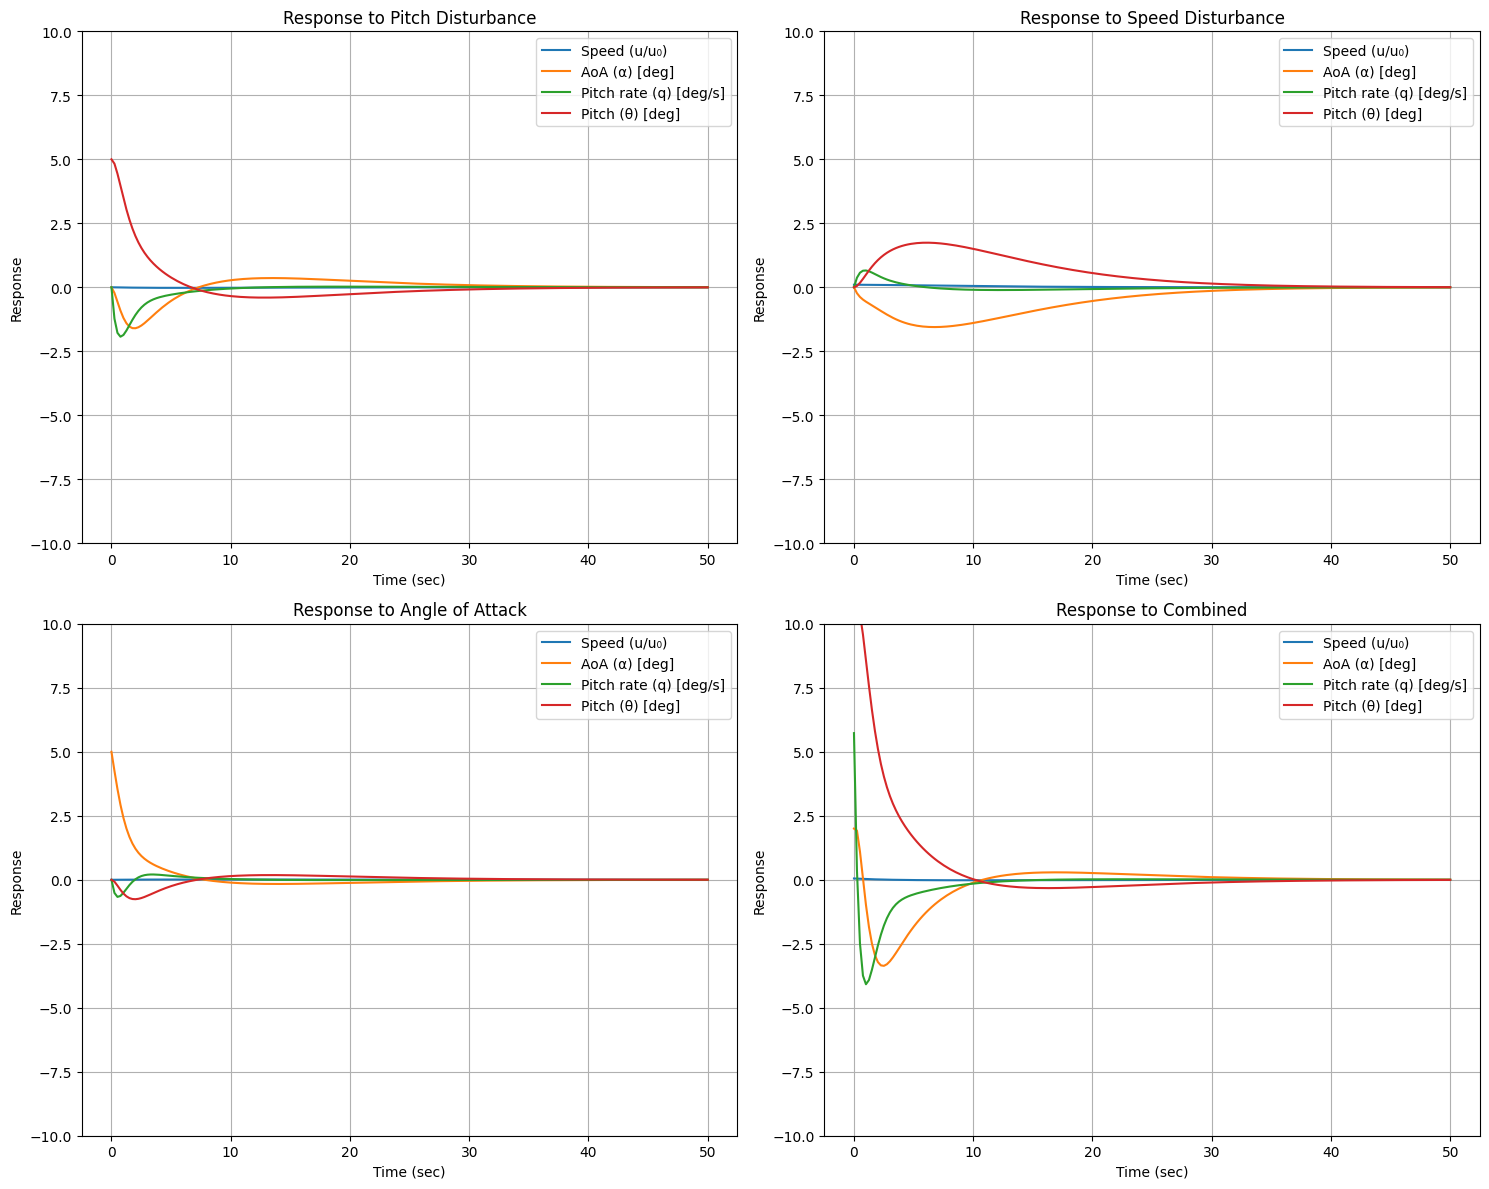

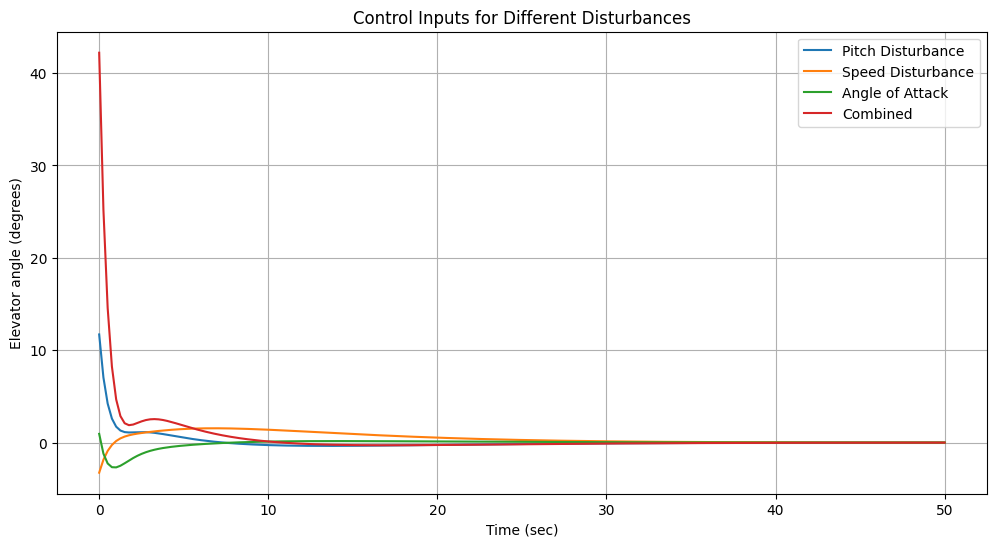

LQR Feedback Gains K:
K_u     = 0.5692
K_alpha = -0.1891
K_q     = -3.4970
K_theta = -2.3410


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, solve_continuous_are
from scipy.integrate import odeint

# Your existing A and B matrices remain the same

# Define Q and R matrices for LQR
# Q penalizes state deviations
# Prioritize angle of attack and pitch rate control
Q = np.diag([1.0, 10.0, 10.0, 5.0])  # Weights for [u/u0, alpha, q, theta]
R = np.array([[1.0]])  # Weight for elevator input

# Solve the continuous-time algebraic Riccati equation
P = solve_continuous_are(A, B, Q, R)

# Calculate the optimal feedback gain K
K = np.dot(np.dot(inv(R), B.T), P)

# Create closed-loop system matrix
A_cl = A - np.dot(B, K)

def closed_loop_response(x0, t):
    """Simulate closed-loop system response"""
    def system(x, t):
        # Control input u = -Kx
        u = -np.dot(K, x)
        return np.dot(A_cl, x)
    
    return odeint(system, x0, t)

# Time vector for simulation
t = np.linspace(0, 50, 200)

# Test different initial conditions
scenarios = {
    'Pitch Disturbance': np.array([0.0, 0.0, 0.0, 5*np.pi/180]),      # 5° pitch
    'Speed Disturbance': np.array([0.1, 0.0, 0.0, 0.0]),               # 10% speed increase
    'Angle of Attack': np.array([0.0, 5*np.pi/180, 0.0, 0.0]),         # 5° AoA
    'Combined': np.array([0.05, 2*np.pi/180, 0.1, 10*np.pi/180])       # Multiple disturbances
}

# Create subplots for each scenario
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, x0) in enumerate(scenarios.items()):
    # Simulate response
    response = closed_loop_response(x0, t)
    
    # Plot states
    axes[i].plot(t, response[:, 0], label='Speed (u/u₀)')
    axes[i].plot(t, response[:, 1]*180/np.pi, label='AoA (α) [deg]')
    axes[i].plot(t, response[:, 2]*180/np.pi, label='Pitch rate (q) [deg/s]')
    axes[i].plot(t, response[:, 3]*180/np.pi, label='Pitch (θ) [deg]')
    axes[i].grid(True)
    axes[i].set_xlabel('Time (sec)')
    axes[i].set_ylabel('Response')
    axes[i].set_title(f'Response to {name}')
    axes[i].legend()
    axes[i].set_ylim(-10, 10)  # Adjust as needed

plt.tight_layout()
plt.show()

# Plot control inputs for each scenario
plt.figure(figsize=(12, 6))
for name, x0 in scenarios.items():
    response = closed_loop_response(x0, t)
    control_input = -np.array([np.dot(K, x) for x in response])
    plt.plot(t, control_input*180/np.pi, label=name)

plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Elevator angle (degrees)')
plt.title('Control Inputs for Different Disturbances')
plt.legend()
plt.show()

# Print the feedback gains
print("LQR Feedback Gains K:")
print(f"K_u     = {K[0][0]:.4f}")
print(f"K_alpha = {K[0][1]:.4f}")
print(f"K_q     = {K[0][2]:.4f}")
print(f"K_theta = {K[0][3]:.4f}")